In [1]:
from omegaconf import OmegaConf
from vitssm.models import build_model
from vitssm.data import get_dataset
import torch

config = OmegaConf.load("configs/UPT/upt_3d_t_32_config.yml")
config.dataset.load_in_memory = False
config.model.upt_autoencoder_checkpoint_path = "/home/david/projects/ViTSSM/checkpoints/ViTSSM/UPT/vmdsprites-UPT_VAE_T-32.pth"

model = build_model(config.model)
dataset = get_dataset(config.dataset)

app_checkpoint_path = "/home/david/projects/ViTSSM/checkpoints/ViTSSM/UPT/vmdsprites-UPT_3D_T-32.pth"
ckpt = torch.load(app_checkpoint_path)
app_ckpt = {key[13:]: val for key, val in ckpt["model"].items() if key.startswith("approximator")}

model.approximator.load_state_dict(app_ckpt)

/home/david/projects/ViTSSM/vitssm/models/upt/_next_frame.py:118: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(upt_autoencoder_checkpoint_path)
/tmp

<All keys matched successfully>

In [19]:
x = dataset[69][0].unsqueeze(0)

torch.Size([128, 3, 32, 32])


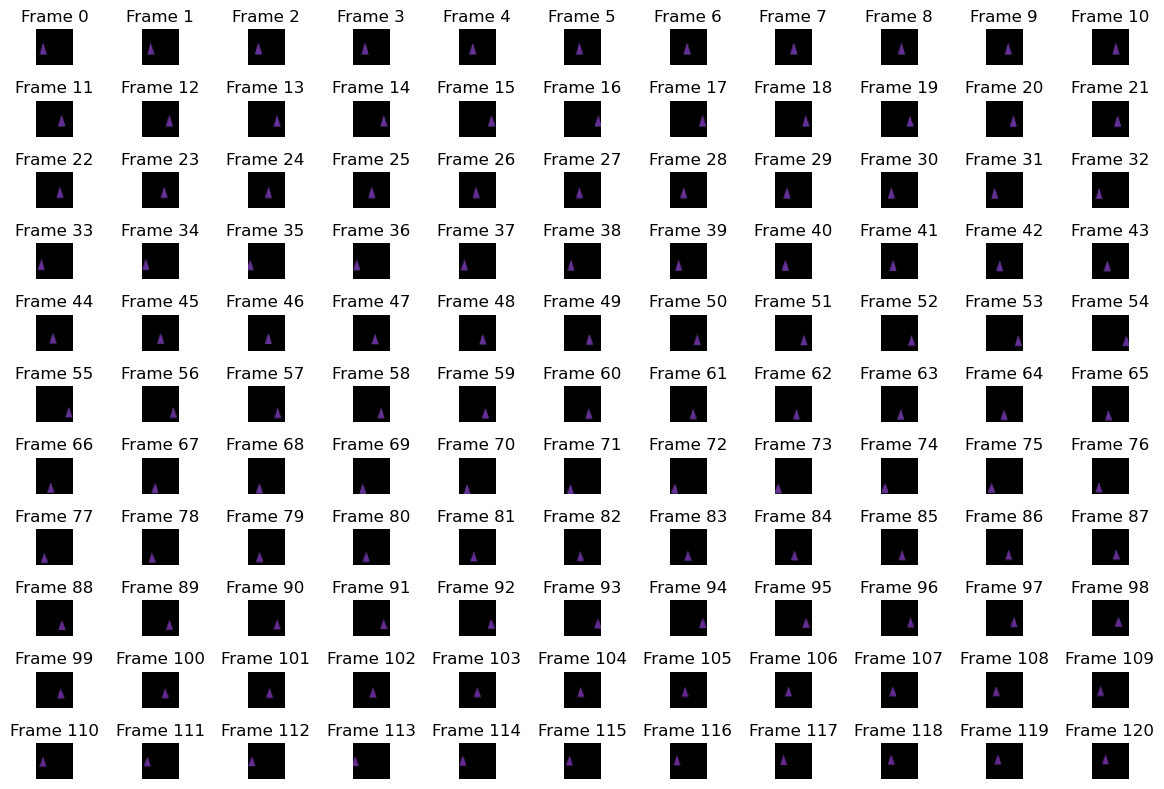

In [20]:
from vitssm.utils.visual import model_output_to_video, display_video_frames_in_grid
from einops import rearrange, repeat
from torchvision.io import write_video
import imageio
import numpy as np

bs, cl, ch, ht, wt = x.shape
spatial_scale = 1
temporal_scale = 1
device = torch.device("cuda")


model.eval()
model.to(device)

x_pred = model.rollout_frames(x.to(device), n_steps=128, temporal_scale=temporal_scale, spatial_scale=spatial_scale).squeeze(0).cpu()

print(x_pred.shape)
display_video_frames_in_grid(x_pred)
imageio.mimsave("x_pred.gif", [np.array(x) for x in rearrange(model_output_to_video(x_pred), "... c h w -> ... h w c")])

In [11]:
imageio.help(".gif")

GIF-PIL - Compuserve GIF via Pillow

    See :mod:`imageio.plugins.pillow_legacy`



In [4]:
import numpy as np

[np.array(x) for x in x_pred]

/tmp/ipykernel_13560/2708407521.py:3: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  [np.array(x) for x in x_pred]


[array([[[-1., -1., -1., ..., -1., -1., -1.],
         [-1., -1., -1., ..., -1., -1., -1.],
         [-1., -1., -1., ..., -1., -1., -1.],
         ...,
         [-1., -1., -1., ..., -1., -1., -1.],
         [-1., -1., -1., ..., -1., -1., -1.],
         [-1., -1., -1., ..., -1., -1., -1.]],
 
        [[-1., -1., -1., ..., -1., -1., -1.],
         [-1., -1., -1., ..., -1., -1., -1.],
         [-1., -1., -1., ..., -1., -1., -1.],
         ...,
         [-1., -1., -1., ..., -1., -1., -1.],
         [-1., -1., -1., ..., -1., -1., -1.],
         [-1., -1., -1., ..., -1., -1., -1.]],
 
        [[-1., -1., -1., ..., -1., -1., -1.],
         [-1., -1., -1., ..., -1., -1., -1.],
         [-1., -1., -1., ..., -1., -1., -1.],
         ...,
         [-1., -1., -1., ..., -1., -1., -1.],
         [-1., -1., -1., ..., -1., -1., -1.],
         [-1., -1., -1., ..., -1., -1., -1.]]], dtype=float32),
 array([[[-1., -1., -1., ..., -1., -1., -1.],
         [-1., -1., -1., ..., -1., -1., -1.],
         [-1.,

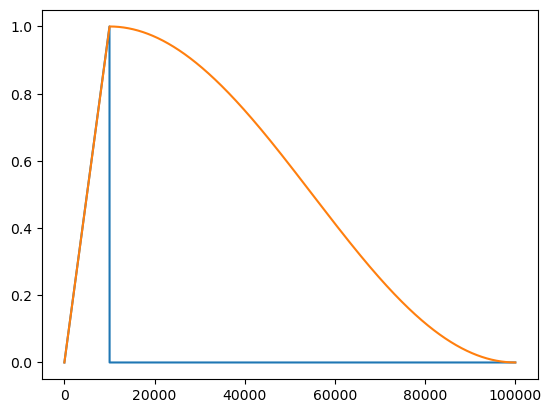

In [2]:
import matplotlib.pyplot as plt
import numpy as np

warmup_steps = 10000
decay_steps = 90000
scheduler_gamma = 0.0


def warm_and_exp_decay_lr(step: int):
    if step < warmup_steps:
        return step / warmup_steps

    return scheduler_gamma ** (step / decay_steps - warmup_steps / decay_steps)

def warm_and_cosine_decay_lr(step: int):
    if step < warmup_steps:
        return step / warmup_steps

    return scheduler_gamma + 0.5 * (1 - scheduler_gamma) * (1 + np.cos((step / decay_steps - warmup_steps / decay_steps) * np.pi))

x = list(range(100000))
y_exp = list(map(warm_and_exp_decay_lr, x))
y_cos = list(map(warm_and_cosine_decay_lr, x))
plt.plot(x, y_exp, label="exp")
plt.plot(x, y_cos, label="cos")

In [ ]:
from vitssm.models.upt._autoencoder import UPTVAE_M
from vitssm.models.upt._approximator import UPTA_M
from vitssm.utils import count_parameters
import torch
from einops import rearrange, repeat

ae = UPTVAE_M(resolution=(4, 32, 32)
app = UPTA_M(context_length=4)

#x = torch.randn(1, 4, 3, 32, 32)
#
#b, f, c, h, w = x.shape
#x = rearrange(x, "b f c h w -> (b f) c h w")
#output_pos = rearrange(
#    torch.stack(torch.meshgrid([torch.arange(32), torch.arange(32)], indexing="ij")),
#    "ndim height width -> (height width) ndim",
#).float()
#
#x = ae.encode(x)
#print(x.shape)
#x = rearrange(x, "(b f) t e -> b f t e", b=b, f=f)
#x = app(x)
#print(x.shape)

print("autoencoder: ", count_parameters(ae))
print("approximator: ", count_parameters(app))
print("total: ", count_parameters(ae) + count_parameters(app))

autoencoder:  2038275
approximator:  894720
total:  2932995


In [1]:
from vitssm.models.dit import DiT_models
from vitssm.utils import count_parameters

model = DiT_models["DiT_M_1"]()
model.initialize_weights()
count_parameters(model)

1057444

In [9]:
from vitssm.models.diffusion import create_diffusion
import torch.nn as nn
import torch

diff = create_diffusion("trailing4")
diff.betas

ImportError: cannot import name 'CaptionProjection' from 'diffusers.models.embeddings' (/home/david/micromamba/envs/vitssm/lib/python3.12/site-packages/diffusers/models/embeddings.py)

In [12]:
import numpy as np
import pandas as pd
import wandb
from vitssm.data import get_dataloaders_next_frame
from vitssm.utils.visual import model_output_to_video
from omegaconf import OmegaConf
import random

config = OmegaConf.load("configs/DIT/dit_tiny_config.yml")
_, eval_loader = get_dataloaders_next_frame(config.dataset)

run = wandb.init(project="test")

for step in range(0, 10, 2):
    rollout_data = []
    roll_steps=[]
    for rollout_step in range(1, 65):
        rollout_data.append(random.randint(1, 10))
        roll_steps.append(rollout_step)
    wandb.log({"ssim": rollout_data, "rollout_step": roll_steps}, step=step)

    #table = wandb.Table(data=rollout_data, columns=["step", "ssim", "psnr"])
    # axes are (time, channel, height, width)
    frames = next(iter(eval_loader))[1]
    run.log(
        {
            #"rollout_metrics": rollout_data,
            #"ssim": wandb.plot.line(table, x="step", y="ssim", title="test over rollout steps"),
            #"psnr": wandb.plot.line(table, x="step", y="test", title="test over rollout steps"),
            "rollout: ground truth vs. prediction": [
                wandb.Video(model_output_to_video(frames[step]),fps=4),
                wandb.Video(model_output_to_video(frames[step+1]), fps=4),
            ],
        }, 
        step=step
    )

run.finish()

In [5]:
model_output_to_video(frames[0]).shape

(16, 32, 32, 3)

In [10]:
run.finish()